In [21]:
import os
import pandas as pd
import numpy as np
import cv2
import torch
import tensorflow as tf


train_path = r"training_words"
test_path = r"testing_words"
val_path = r"validation_words"

print("Train Exists:", os.path.exists(train_path))
print("Test Exists:", os.path.exists(test_path))
print("Validation Exists:", os.path.exists(val_path))


Train Exists: True
Test Exists: True
Validation Exists: True


In [23]:
import pandas as pd
import os

# Load CSV files into DataFrames
train_df = pd.read_csv("training_labels.csv")  # Update with actual path if different
test_df = pd.read_csv("testing_labels.csv")
val_df = pd.read_csv("validation_labels.csv")

# Check the first few rows
print(train_df.head())


   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol


In [27]:
print(train_df.columns)

Index(['IMAGE', 'MEDICINE_NAME', 'GENERIC_NAME'], dtype='object')


In [39]:
import os

train_df['image_path'] = train_df['IMAGE'].apply(lambda x: os.path.join(
    r"D:\payal\CODECRAFT HACKATHON\training_words", x))

test_df['image_path'] = test_df['IMAGE'].apply(lambda x: os.path.join(
    r"D:\payal\CODECRAFT HACKATHON\testing_words", x))

val_df['image_path'] = val_df['IMAGE'].apply(lambda x: os.path.join(
    r"D:\payal\CODECRAFT HACKATHON\validation_words", x))

# Check if the paths are correct
print(train_df.head())
print(test_df.head())
print(val_df.head())


   IMAGE MEDICINE_NAME GENERIC_NAME  \
0  0.png         Aceta  Paracetamol   
1  1.png         Aceta  Paracetamol   
2  2.png         Aceta  Paracetamol   
3  3.png         Aceta  Paracetamol   
4  4.png         Aceta  Paracetamol   

                                          image_path  
0  D:\payal\CODECRAFT HACKATHON\training_words\0.png  
1  D:\payal\CODECRAFT HACKATHON\training_words\1.png  
2  D:\payal\CODECRAFT HACKATHON\training_words\2.png  
3  D:\payal\CODECRAFT HACKATHON\training_words\3.png  
4  D:\payal\CODECRAFT HACKATHON\training_words\4.png  
   IMAGE MEDICINE_NAME GENERIC_NAME  \
0  0.png         Aceta  Paracetamol   
1  1.png         Aceta  Paracetamol   
2  2.png         Aceta  Paracetamol   
3  3.png         Aceta  Paracetamol   
4  4.png         Aceta  Paracetamol   

                                         image_path  
0  D:\payal\CODECRAFT HACKATHON\testing_words\0.png  
1  D:\payal\CODECRAFT HACKATHON\testing_words\1.png  
2  D:\payal\CODECRAFT HACKATHON\testin

## Load & Preprocess Images

Number of Classes: 78
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


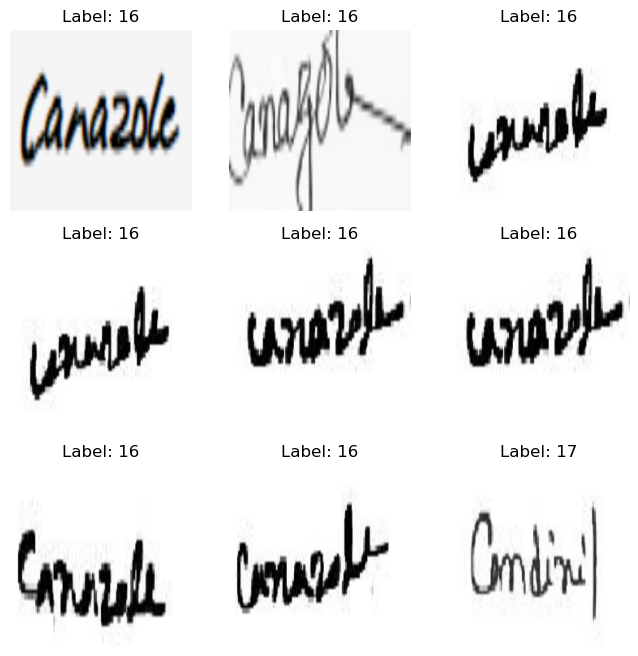

In [45]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load CSV files
train_df = pd.read_csv("training_labels.csv")
test_df = pd.read_csv("testing_labels.csv")
val_df = pd.read_csv("validation_labels.csv")

# Define image size
IMG_SIZE = (224, 224)  # Standard size for CNN models
BATCH_SIZE = 32

# Update DataFrames to include full image paths
train_df['image_path'] = train_df['IMAGE'].apply(lambda x: os.path.join(r"D:\payal\CODECRAFT HACKATHON\training_words", x))
test_df['image_path'] = test_df['IMAGE'].apply(lambda x: os.path.join(r"D:\payal\CODECRAFT HACKATHON\testing_words", x))
val_df['image_path'] = val_df['IMAGE'].apply(lambda x: os.path.join(r"D:\payal\CODECRAFT HACKATHON\validation_words", x))

# Encode labels (Convert medicine names to numerical labels)
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['MEDICINE_NAME'])
test_df['label'] = label_encoder.transform(test_df['MEDICINE_NAME'])
val_df['label'] = label_encoder.transform(val_df['MEDICINE_NAME'])

# Save class mapping for later use
num_classes = len(label_encoder.classes_)
print(f"Number of Classes: {num_classes}")

# Function to load and preprocess images
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG
    image = tf.image.resize(image, IMG_SIZE)  # Resize to fixed size
    image = image / 255.0  # Normalize pixel values (0-1)
    return image, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['label'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['image_path'].values, test_df['label'].values))
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['label'].values))

# Apply preprocessing function
train_dataset = train_dataset.map(load_image).batch(BATCH_SIZE).shuffle(1000)
test_dataset = test_dataset.map(load_image).batch(BATCH_SIZE)
val_dataset = val_dataset.map(load_image).batch(BATCH_SIZE)

# Check if dataset is working
for image_batch, label_batch in train_dataset.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")

    # Show some sample images
    plt.figure(figsize=(8, 8))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy())
        plt.title(f"Label: {label_batch[i].numpy()}")
        plt.axis("off")
    plt.show()


## Build & Compile the CNN Model

In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 with pre-trained weights and remove the top layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# Freeze base model layers (so they don’t get trained initially)
base_model.trainable = False

# Build the CNN model
model = models.Sequential([
    base_model,  # Pretrained base model
    layers.GlobalAveragePooling2D(),  # Convert feature maps to a vector
    layers.Dense(256, activation="relu"),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(num_classes, activation="softmax")  # Output layer (softmax for multi-class classification)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Model Summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 78)                  │          20,046 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,605,966 (9.94 MB)

 Trainable params: 347,982 (1.33 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Train the CNN Model

In [51]:
# Define training parameters
EPOCHS = 10  # Adjust based on dataset size
STEPS_PER_EPOCH = len(train_df) // BATCH_SIZE
VALIDATION_STEPS = len(val_df) // BATCH_SIZE

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS
)


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 99s 785ms/step - accuracy: 0.0072 - loss: 5.1160 - val_accuracy: 0.0365 - val_loss: 4.3490
Epoch 2/10
 1/97 ━━━━━━━━━━━━━━━━━━━━ 57s 595ms/step - accuracy: 0.0000e+00 - loss: 4.3787

C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.0000e+00 - loss: 4.3787 - val_accuracy: 0.0378 - val_loss: 4.3494
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 70s 712ms/step - accuracy: 0.0238 - loss: 4.3542 - val_accuracy: 0.0573 - val_loss: 4.3264
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.0000e+00 - loss: 4.3494 - val_accuracy: 0.0573 - val_loss: 4.3262
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 71s 713ms/step - accuracy: 0.0156 - loss: 4.3381 - val_accuracy: 0.0534 - val_loss: 4.2080
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.0000e+00 - loss: 4.4265 - val_accuracy: 0.0521 - val_loss: 4.2156
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 71s 721ms/step - accuracy: 0.0227 - loss: 4.2654 - val_accuracy: 0.0742 - val_loss: 4.0770
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.2500 - loss: 3.4317 - val_accuracy: 0.0716 - val_loss: 4.0741
Epoch 9/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 70s 709ms/step - accuracy: 0.0432 - loss: 4.1733 - val_acc

In [59]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 643ms/step - accuracy: 0.0781 - loss: 3.9998
Test Accuracy: 5.64%


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


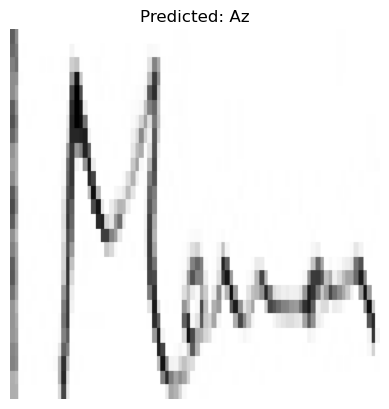

In [61]:
import random
from tensorflow.keras.preprocessing import image

# Pick a random test image
random_idx = random.randint(0, len(test_df) - 1)
img_path = test_df.iloc[random_idx]['image_path']

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = tf.expand_dims(img_array, axis=0)

# Make prediction
prediction = model.predict(img_array)
predicted_label = label_encoder.inverse_transform([tf.argmax(prediction[0]).numpy()])[0]

# Show the image & prediction
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()


In [65]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20  # Increased for better learning

# Load CSV files
train_df = pd.read_csv("training_labels.csv")
test_df = pd.read_csv("testing_labels.csv")
val_df = pd.read_csv("validation_labels.csv")

# Update DataFrames to include full image paths
train_df['image_path'] = train_df['IMAGE'].apply(lambda x: os.path.join("D:/payal/CODECRAFT HACKATHON/training_words", x))
test_df['image_path'] = test_df['IMAGE'].apply(lambda x: os.path.join("D:/payal/CODECRAFT HACKATHON/testing_words", x))
val_df['image_path'] = val_df['IMAGE'].apply(lambda x: os.path.join("D:/payal/CODECRAFT HACKATHON/validation_words", x))

# Encode labels
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['MEDICINE_NAME']).astype(str)
test_df['label'] = label_encoder.transform(test_df['MEDICINE_NAME']).astype(str)
val_df['label'] = label_encoder.transform(val_df['MEDICINE_NAME']).astype(str)

num_classes = len(label_encoder.classes_)
print(f"Number of Classes: {num_classes}")

# Image augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='image_path', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df, x_col='image_path', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df, x_col='image_path', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False
)

# Load MobileNetV2
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze initial layers

# Model definition
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

# Fine-tuning: Unfreeze some layers
base_model.trainable = True
for layer in base_model.layers[:100]:  # Keep first 100 layers frozen
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train again
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Number of Classes: 78
Found 3120 validated image filenames belonging to 78 classes.
Found 780 validated image filenames belonging to 78 classes.
Found 780 validated image filenames belonging to 78 classes.


C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.0488 - loss: 4.4585 - val_accuracy: 0.1962 - val_loss: 3.5025
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.1482 - loss: 3.6022 - val_accuracy: 0.2782 - val_loss: 3.0305
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.2174 - loss: 3.1976 - val_accuracy: 0.3667 - val_loss: 2.7049
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.2790 - loss: 2.8546 - val_accuracy: 0.3846 - val_loss: 2.5219
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.3243 - loss: 2.6348 - val_accuracy: 0.4167 - val_loss: 2.3628
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.3734 - loss: 2.4738 - val_accuracy: 0.4218 - val_loss: 2.2197
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.3950 - loss: 2.3196 - val_accuracy: 0.4705 - val_loss: 2.1338
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.4186 - loss: 2.2317 - val_accuracy: 0.5128 - v